# Notebook to test the validity of MDS on our data

Imports

In [51]:
import numpy as np

from matplotlib import pyplot as plt
from matplotlib.collections import LineCollection
%matplotlib widget

from sklearn import manifold
from sklearn.metrics import euclidean_distances
from sklearn.decomposition import PCA

import h5py

Load a graph

In [52]:
EPSILON = np.finfo(np.float32).eps
seed = np.random.RandomState(seed=3)
# n_samples = 20
# X_true = seed.randint(0, 20, 2 * n_samples).astype(float)
# X_true = X_true.reshape((n_samples, 2))
# # Center the data
# X_true -= X_true.mean()

with h5py.File('graphs_h5/graph_AntiFlourite_Ra2O_r5.h5', 'r') as file:
    node_features = np.array(file['node_attributes'][:], dtype=float) # Node attributes
    X_true = node_features[:, 4:7]
    n_samples = X_true.shape[0]

similarities = euclidean_distances(X_true)

Add noise to similarities

In [53]:
noise = np.random.rand(n_samples, n_samples)
noise = noise + noise.T
noise[np.arange(noise.shape[0]), np.arange(noise.shape[0])] = 0
# similarities += noise

MDS

In [54]:
mds = manifold.MDS(
    n_components=3,
    metric=False,
    max_iter=3000,
    eps=1e-9,
    random_state=seed,
    dissimilarity="precomputed",
    n_jobs=1,
    normalized_stress="auto",
)
pos = mds.fit(similarities).embedding_

NMDS

In [55]:
nmds = manifold.MDS(
    n_components=3,
    metric=False,
    max_iter=3000,
    eps=1e-12,
    dissimilarity="precomputed",
    random_state=seed,
    n_jobs=1,
    n_init=1,
    normalized_stress="auto",
)
npos = nmds.fit_transform(similarities, init=pos)

Rescaling and rotation

In [56]:
# Rescale the data
pos *= np.sqrt((X_true**2).sum()) / np.sqrt((pos**2).sum())
npos *= np.sqrt((X_true**2).sum()) / np.sqrt((npos**2).sum())

# Rotate the data
clf = PCA(n_components=3)
X_true = clf.fit_transform(X_true)

pos = clf.fit_transform(pos)

npos = clf.fit_transform(npos)

Plot the data

In [57]:
X_true.shape

(23, 3)

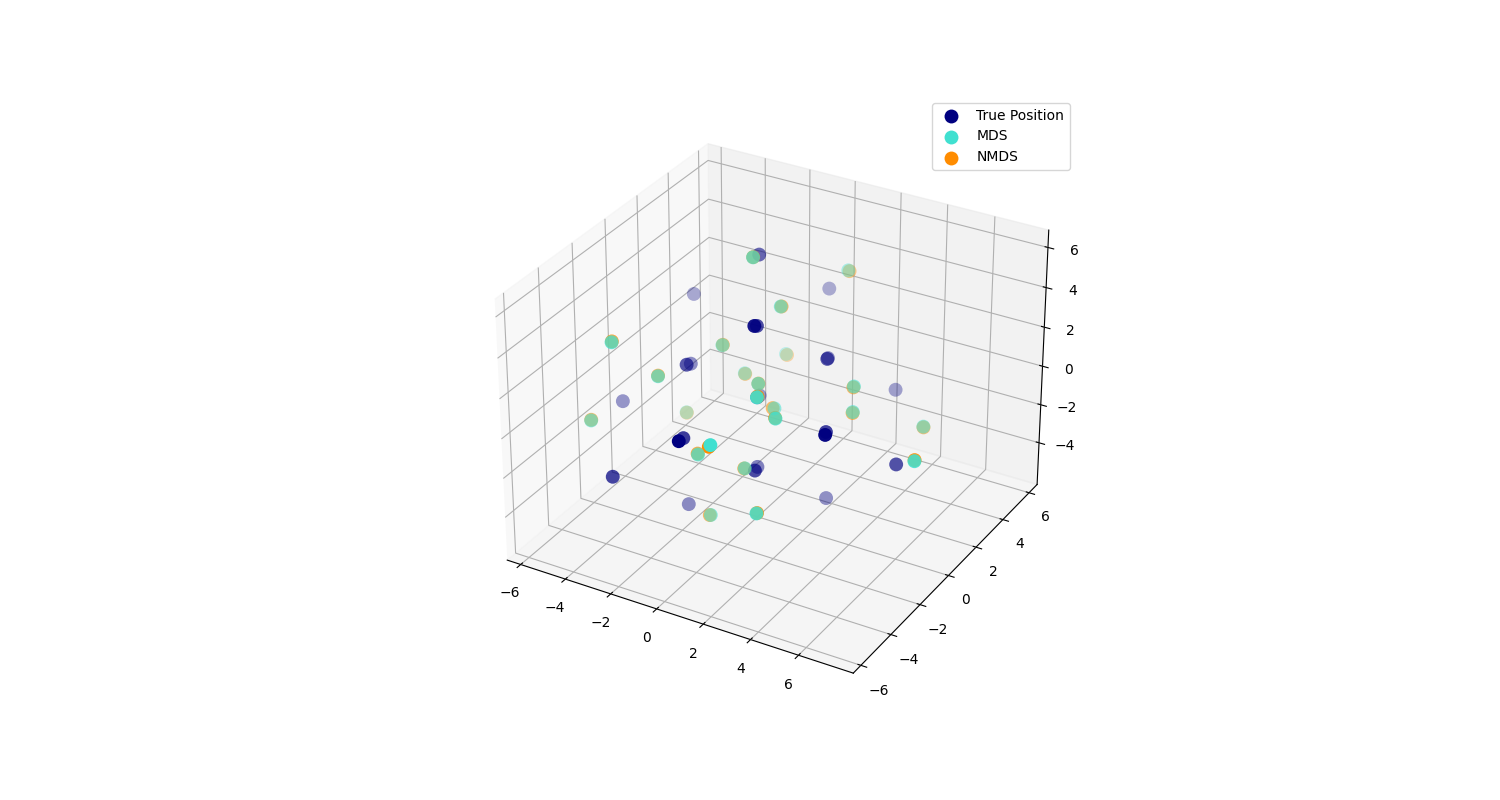

In [58]:
fig = plt.figure(figsize=(15, 8))
ax = fig.add_subplot(projection='3d')

s = 100
ax.scatter(X_true[:, 0], X_true[:, 1], X_true[:, 2], color="navy", s=s, lw=0, label="True Position")
ax.scatter(pos[:, 0], pos[:, 1], pos[:, 2], color="turquoise", s=s, lw=0, label="MDS")
ax.scatter(npos[:, 0], npos[:, 1], npos[:, 2], color="darkorange", s=s, lw=0, label="NMDS")
plt.legend(scatterpoints=1, loc="best", shadow=False)

similarities = similarities.max() / (similarities + EPSILON) * 100
np.fill_diagonal(similarities, 0)
# Plot the edges
start_idx, end_idx = np.where(pos)
# a sequence of (*line0*, *line1*, *line2*), where::
#            linen = (x0, y0), (x1, y1), ... (xm, ym)
# segments = [
#     [X_true[i, :], X_true[j, :]] for i in range(len(pos)) for j in range(len(pos))
# ]
# values = np.abs(similarities)
# lc = LineCollection(
#     segments, zorder=0, cmap=plt.cm.Blues, norm=plt.Normalize(0, values.max())
# )
# lc.set_array(similarities.flatten())
# lc.set_linewidths(np.full(len(segments), 0.5))
# ax.add_collection(lc)

plt.show()

In [61]:
np.mean(X_true - pos)**2,np.mean(X_true - npos)**2

(2.651076346048349e-33, 1.4912304446521961e-33)